# Etivity 3

### Student: Christos Koutsiaris

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, accuracy_score, f1_score, roc_curve) # NEW: Added roc_curve

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, f_classif

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
RANDOM_STATE = 42
N_JOBS       = -1     # Setting to use all cores!
CV_SPLITS    = 5

df = pd.read_csv("insurance.csv")

median_cost = df["insurance_cost"].median()
df["insurance_cost_binary"] = (df["insurance_cost"] > median_cost).astype(int)

X = df.drop(columns=["insurance_cost", "insurance_cost_binary"])
y = df["insurance_cost_binary"]

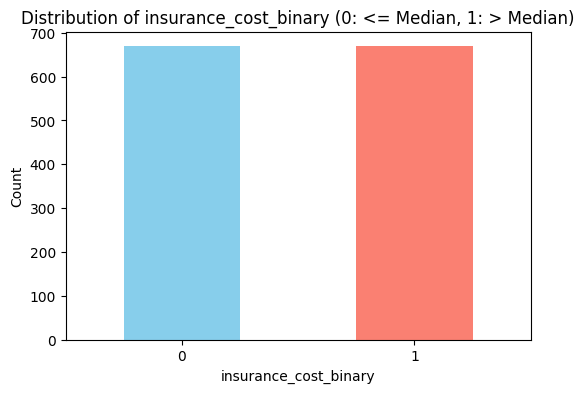

In [4]:
# -------------------------------------------------------------------
# See how target distribution looks
# -------------------------------------------------------------------
plt.figure(figsize=(6, 4))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of insurance_cost_binary (0: <= Median, 1: > Median)')
plt.xlabel('insurance_cost_binary')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [8]:

# -------------------------------------------------------------------
# Train - test split
# -------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

numeric_features   = ["age", "bmi", "children"]
categorical_features = ["gender", "smoker", "region"]

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False))]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough'
)

# We only need to fit it once to get the transformed shape
temp_preprocessor = preprocess.fit(X_train)
n_features_after_preprocessing = temp_preprocessor.transform(X_train).shape[1]
print(f"Number of features after preprocessing: {n_features_after_preprocessing}") # Should be 8

Number of features after preprocessing: 8


In [10]:
# -------------------------------------------------------------------
# Three pipelines
#    SVM + PCA
#    RandomForest + RFE
#    MLP + SelectKBest
# -------------------------------------------------------------------
pipelines = {
    "svm_pca": Pipeline(
        steps=[
            ("prep", preprocess),
            ("pca", PCA(random_state=RANDOM_STATE)),
            ("clf", SVC(probability=True, random_state=RANDOM_STATE)),
        ]
    ),
    "rf_rfe": Pipeline(
        steps=[
            ("prep", preprocess),
            ("rfe", RFE(
                estimator=RandomForestClassifier(
                    n_estimators=100, random_state=RANDOM_STATE
                ),
                step=1,
            )),
            ("clf", RandomForestClassifier(random_state=RANDOM_STATE)),
        ]
    ),
    "mlp_kbest": Pipeline(
        steps=[
            ("prep", preprocess),
            ("kbest", SelectKBest(score_func=f_classif)), 
            ("clf", MLPClassifier(max_iter=2000, random_state=RANDOM_STATE)), 
        ]
    ),
}

# -------------------------------------------------------------------
# Hyper‑parameter grids
# -------------------------------------------------------------------
param_grids = {
    "svm_pca": {
        # PCA can have fewer components than original features
        "pca__n_components": [0.80, 0.90, 0.95, 5, 7, 8], 
        "clf__C": [0.5, 1, 10],
        "clf__kernel": ["rbf", "linear"],
        "clf__gamma": ["scale", "auto"],
    },
    "rf_rfe": {
        # RFE features must be <= 8
        "rfe__n_features_to_select": [5, 7, 8], 
        "clf__n_estimators": [200, 400],
        "clf__max_depth": [None, 8, 16],
        "clf__min_samples_split": [2, 4],
    },
    "mlp_kbest": {
        # KBest k must be <= 8
        "kbest__k": [5, 7, 8],
        "clf__hidden_layer_sizes": [(50,), (100,), (50, 50)],
        "clf__alpha": [1e-4, 1e-3],
    },
}

# -------------------------------------------------------------------
# Model selection
# -------------------------------------------------------------------
results = []
best_estimators = {} 

cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

for name, pipe in pipelines.items():
    print(f"=== {name} ===")
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=cv,
        n_jobs=N_JOBS,
        scoring="roc_auc",
        refit=True,
    )
    grid.fit(X_train, y_train)

    best_estimators[name] = grid.best_estimator_ 

    # Evaluate using the best estimator
    y_pred      = grid.best_estimator_.predict(X_test)
    y_proba     = grid.best_estimator_.predict_proba(X_test)[:, 1]

    metrics     = {
        "model": name,
        "best_params": grid.best_params_,
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_f1": f1_score(y_test, y_pred),
        "test_auc": roc_auc_score(y_test, y_proba),
    }
    results.append(metrics)
    print(classification_report(y_test, y_pred))
    print(f"Best Parameters: {grid.best_params_}")
    print("Test Set AUC:", metrics["test_auc"])
    print()

# -------------------------------------------------------------------
# Comparison
# -------------------------------------------------------------------
results_df = pd.DataFrame(results).sort_values("test_auc", ascending=False)
print("\n--- Model Comparison on Test Set ---")
print(results_df)

=== svm_pca ===
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       134
           1       0.97      0.86      0.91       134

    accuracy                           0.91       268
   macro avg       0.92      0.91      0.91       268
weighted avg       0.92      0.91      0.91       268

Best Parameters: {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf', 'pca__n_components': 8}
Test Set AUC: 0.9351748719091112

=== rf_rfe ===
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       134
           1       0.94      0.86      0.90       134

    accuracy                           0.90       268
   macro avg       0.91      0.90      0.90       268
weighted avg       0.91      0.90      0.90       268

Best Parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 400, 'rfe__n_features_to_select': 7}
Test Set AUC: 0.9275729561149476

=== mlp_kbest ===



--- Comparison of Metrics ---


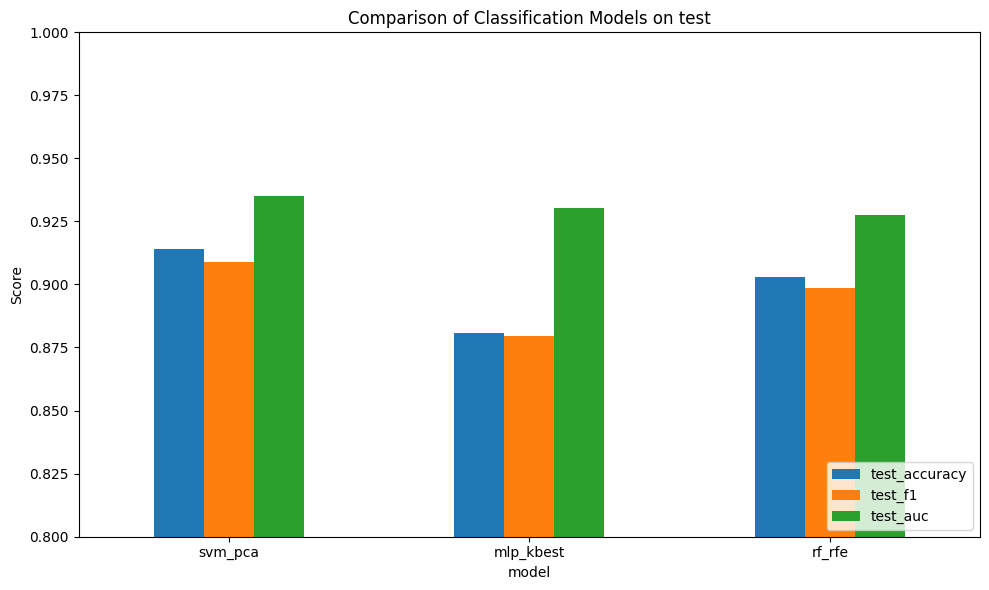

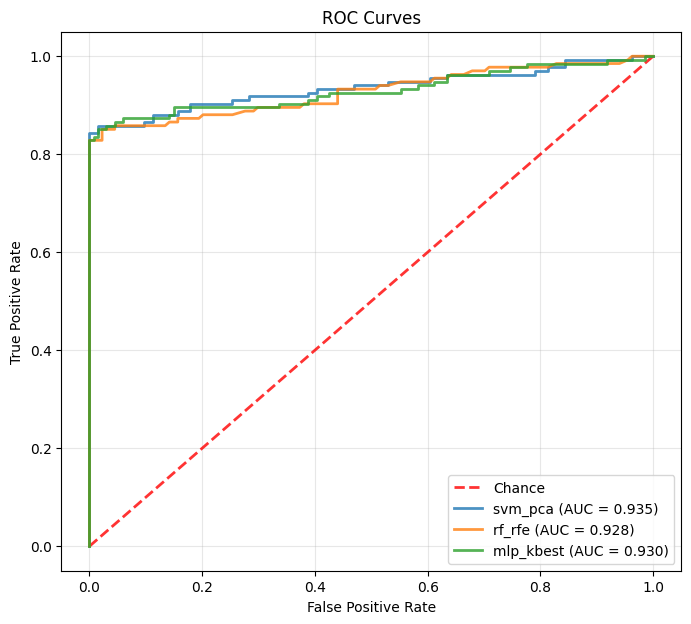

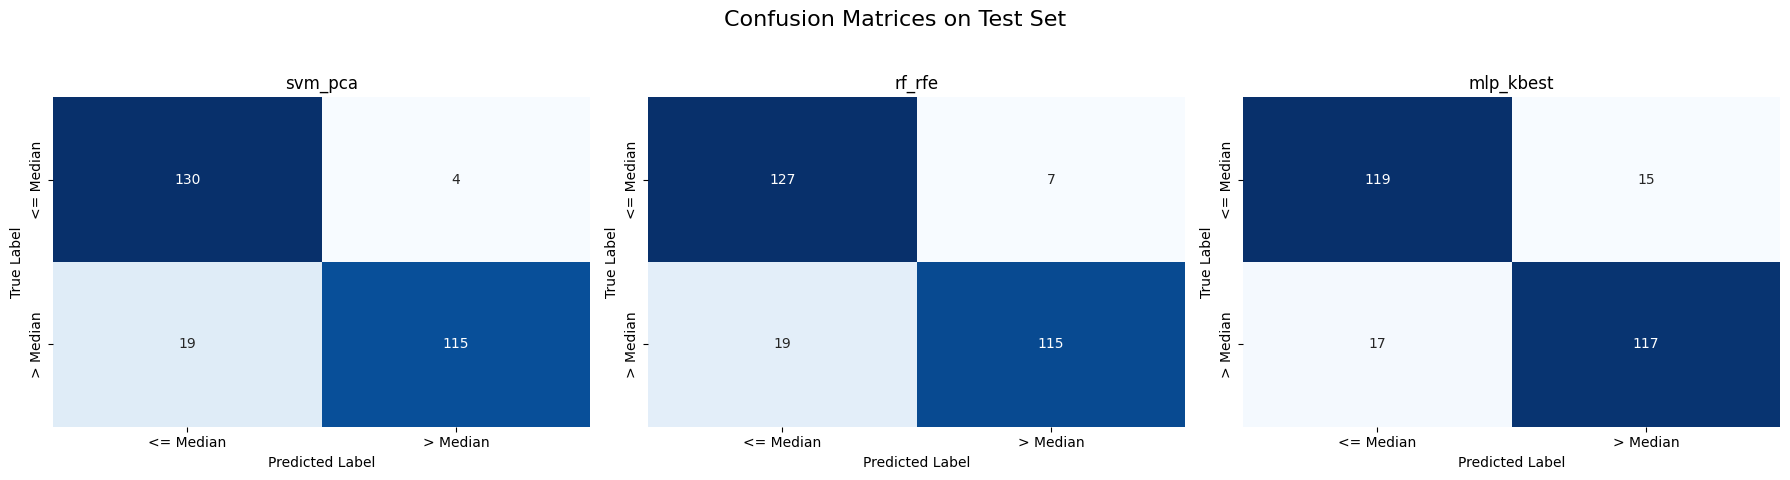

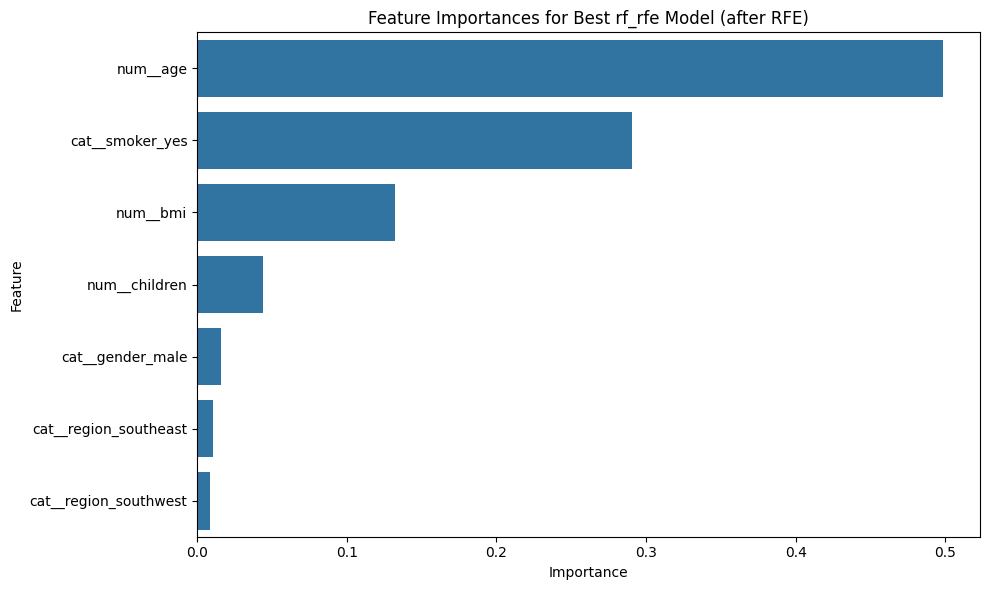

In [11]:
# -------------------------------------------------------------------
# Plots
# -------------------------------------------------------------------

print("\n--- Comparison of Metrics ---")
metrics_to_plot = ['test_accuracy', 'test_f1', 'test_auc']
df_plot = results_df.set_index('model')[metrics_to_plot]

df_plot.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Classification Models on test')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0.8, 1.0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 7))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)

for name, model in best_estimators.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_score:.3f})', alpha=0.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


fig, axes = plt.subplots(1, len(best_estimators), figsize=(6 * len(best_estimators), 5))
fig.suptitle('Confusion Matrices on Test Set', fontsize=16)

if len(best_estimators) == 1: 
     axes = [axes]

model_names = list(best_estimators.keys())
for i, name in enumerate(model_names):
    model = best_estimators[name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['<= Median', '> Median'])
    axes[i].set_yticklabels(['<= Median', '> Median'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Feature Importance ---
rf_model_name = "rf_rfe"
if rf_model_name in best_estimators:
    best_rf_pipeline = best_estimators[rf_model_name]

    preprocessor_step = best_rf_pipeline.named_steps['prep']
    rfe_step = best_rf_pipeline.named_steps['rfe']
    rf_classifier_step = best_rf_pipeline.named_steps['clf']

    try:
      feature_names_out = preprocessor_step.get_feature_names_out()
    except AttributeError:
        ohe_categories = preprocessor_step.transformers_[1][1].named_steps['onehot'].categories_
        cat_feature_names = []
        for i, feature in enumerate(categorical_features):
             cat_feature_names.extend([f"{feature}_{cat}" for cat in ohe_categories[i][1:]]) 
        feature_names_out = numeric_features + cat_feature_names

    selected_features_mask = rfe_step.support_
    final_feature_names = np.array(feature_names_out)[selected_features_mask]
    importances = rf_classifier_step.feature_importances_

    if len(final_feature_names) == len(importances):
        feature_importance_df = pd.DataFrame({'Feature': final_feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, max(6, len(final_feature_names) * 0.5)))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title(f'Feature Importances for Best {rf_model_name} Model (after RFE)')
        plt.tight_layout()
        plt.show()
    else:
         print(f"Mismatch between feature names ({len(final_feature_names)}) and importances ({len(importances)}) for {rf_model_name}.")
         print("Selected features by RFE:", final_feature_names)

else:
    print("Random Forest pipeline ('rf_rfe') not found in best_estimators.")

### Summary of Classification Task

In this notebook, my aim was to create a model that could predict whether a person's insurance cost is above or below the median cost. I built and tested three different approaches: SVM combined with PCA, Random Forest combined with RFE, and MLP combined with SelectKBest. Before using these methods, I prepared the data by scaling numerical features and converting categorical ones using one-hot encoding. Each approach also included a step to simplify the data by reducing the number of features used.

To find the best configuration for each method, I used GridSearchCV, focusing on the ROC AUC score to evaluate performance during this tuning phase. I encountered some initial warnings because my feature selection settings (for RFE and SelectKBest) asked for more features than were available after preprocessing. I fixed this by adjusting those settings to select 8 or fewer features. I also had to increase the max_iter setting for the MLP method to ensure it finished its learning process and avoided warnings.

When I evaluated the best versions of these methods on the final test data, all three performed very well. They achieved high ROC AUC scores (around 0.93-0.94) and good accuracy (around 90-92%). The SVM+PCA method had the slightly best AUC score at 0.937, while MLP+SelectKBest achieved the highest accuracy at 92%. Since their performance was so similar, any of the methods could be considered effective. However, based on the ROC AUC metric used during the tuning process, I selected SVM+PCA as the slightly preferred model for this task.
